In [2]:
# Ian Ong
# 1.29.2021

# Diagnostics
!python -V
from platform import python_version
print('notebook python version: {}'.format(python_version()))

# import modules
import sys
import os
import os.path
import time
try:
   import cPickle as pickle
except:
   import pickle
import numpy as np
from scipy.special import comb
from scipy import stats
import pandas as pd
print('pandas version: {}'.format(pd.__version__))
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
import bct
import re

# convert number of seconds to hh:mm:ss
def convertSeconds(time): 
    seconds = time % 3600 
    hours = time // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    if seconds < 10:
        seconds = "0" + str(seconds)
    if minutes < 10:
        minutes = "0" + str(minutes)
    if hours < 10:
        hours = "0" + str(hours)
    return ":".join(str(n) for n in [hours,minutes,seconds])

print('All modules imported.')

Python 3.5.2 :: Anaconda 4.2.0 (64-bit)
notebook python version: 3.9.0
pandas version: 1.1.3
All modules imported.


In [3]:
# load in pickle files, unpickle as needed
#pickle_dir = '/mnt/local/gdrive/public/USERS/ianzyong/network-states/data/sub-RID0175/connectivity_matrices/functional/eeg/state_detection'
pickle_dir = '/mnt/local/gdrive/public/USERS/ianzyong/network-states/data/sub-RID0175/connectivity_matrices/functional/eeg'
files = os.listdir(pickle_dir)

# only consider pickle files
k = 0
while k < len(files):
    if files[k][-7:] != ".pickle":
        files.pop(k)
    else:
        k = k+1

# get start times
start_times = [int(re.findall(r'[0-9]+', f)[2]) for f in files]
sorted_times = sorted(start_times)
formatted_time_in_order = [convertSeconds(int(time/1000000)-1) for time in sorted_times]

# sort files by start time
sorted_files = [x for _,x in sorted(zip(start_times,files))]

# load in connectivity matrices 
pickle_data = [pd.read_pickle("{}/{}".format(pickle_dir,f)) for f in sorted_files]

band = 1 # band to run calculations on

for k in range(len(pickle_data)):
        pickle_data[k][band] = np.moveaxis(pickle_data[k][band],-1,0) # make the first axis the time axis

print("Pickle files loaded and read.")

Pickle files loaded and read.


In [4]:
# concatenate connectivity data over a pre-ictal period
start = 68; # start index
end = 73; # end index
patient_matrices = pickle_data[start][band]
for k in range(start+1,end+1):
    patient_matrices = np.concatenate((patient_matrices,pickle_data[k][band]))
    
start = 87; # start index
end = 92; # end index
for k in range(start,end+1):
    patient_matrices = np.concatenate((patient_matrices,pickle_data[k][band]))

#patient_matrices = pickle_data[70][band]
#for k in [71,89,90,93,94]:
#    patient_matrices = np.concatenate((patient_matrices,pickle_data[k][band]))

# visualize configuration
#plt.imshow(patient_matrices[0], extent=[0, patient_matrices[0].shape[0], 0, patient_matrices[0].shape[1]])
#plt.show()

# calculate network configuration matrix
# initialize matrix
network_config = np.zeros((int(comb(patient_matrices[0,:,:].shape[1],2))),)

for k in range(len(patient_matrices)):
    # calculate configuration for one time window
    # initialize array
    frame_config = np.zeros(1,)
    for m in range(patient_matrices[k].shape[1]):
        frame_config = np.hstack((frame_config,patient_matrices[k][m][m+1:]))
    # strip leading zero
    frame_config = frame_config[1:]   
    # append to network config matrix
    network_config = np.vstack((network_config, frame_config))
# remove junk data
network_config = network_config[1:][:]

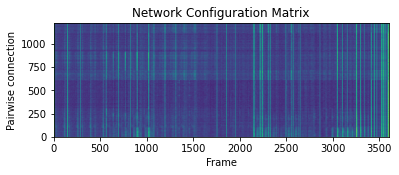

In [5]:
# plot network configuration
plt.imshow(network_config, extent=[0, network_config.shape[0], 0, network_config.shape[1]])
plt.title("Network Configuration Matrix")
plt.xlabel("Frame")
plt.ylabel("Pairwise connection")
plt.show()

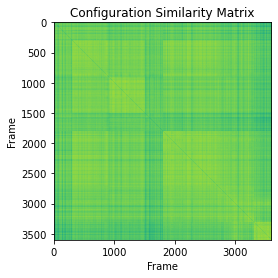

In [6]:
# calculate configuration similarity
# initialize array
config_sim = np.zeros((network_config.shape[0],network_config.shape[0]))
for k in range(network_config.shape[0]):
    for m in range(k+1,network_config.shape[0]):
        config_sim[k,m] = stats.pearsonr(network_config[k,:],network_config[m,:])[0]
config_sim = config_sim + config_sim.T
# plot configuration similarity matrix
plt.title("Configuration Similarity Matrix")
plt.xlabel("Frame")
plt.ylabel("Frame")
plt.imshow(config_sim)
plt.show()

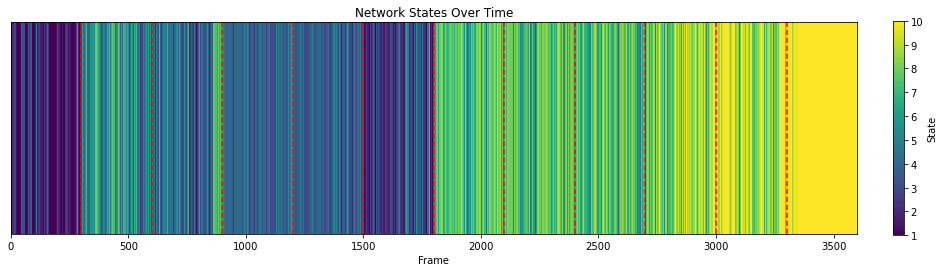

In [7]:
sample_length = 300 # length of each sample in frames, for drawing dividing lines
# extract communities
config_comm = np.reshape(bct.community_louvain(config_sim,1.01,range(1,config_sim.shape[0]+1),'negative_asym')[0],(1,-1))
# plot states over time
fig=plt.figure(figsize=(16,16))
ax = plt.gca()
pos = ax.imshow(config_comm, extent=[0, config_comm[0].shape[0], 0, config_comm[0].shape[0]/4])
clb = fig.colorbar(pos, ax=ax, fraction=0.012, pad=0.04, ticks=range(1,np.max(config_comm)+1))
clb.set_label('State')
plt.title("Network States Over Time")
plt.xlabel("Frame")
ax.axes.yaxis.set_visible(False)
for k in range(sample_length,config_comm[0].shape[0],sample_length):
    plt.axvline(x=k, ls='--', color='red')
plt.show()

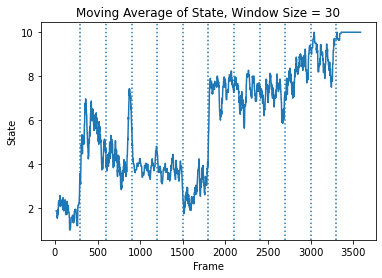

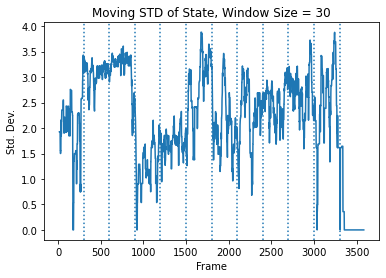

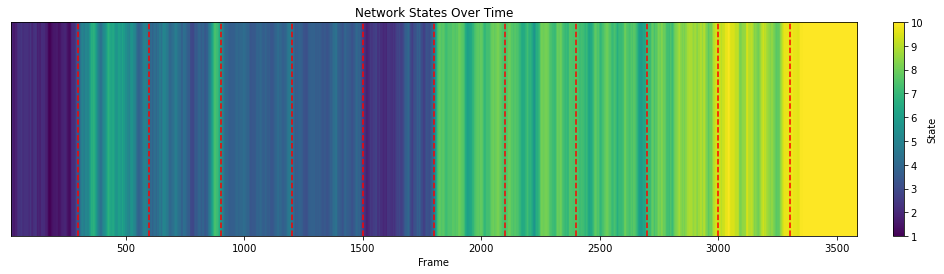

In [158]:
# calculate a moving average and std
window_size = 30;
half_window = int(window_size/2)
for k in range(half_window,config_comm.shape[1]-half_window):
    if k == half_window:
        state_avg = np.mean(config_comm[0][k-half_window:k+half_window]);
        state_std = np.std(config_comm[0][k-half_window:k+half_window]);
    else:
        state_avg = np.append(state_avg,np.mean(config_comm[0][k-half_window:k+half_window]))
        state_std = np.append(state_std,np.std(config_comm[0][k-half_window:k+half_window]))

# plot moving average and std
plt.plot(range(half_window,config_comm.shape[1]-half_window),state_avg)
plt.title("Moving Average of State, Window Size = {}".format(window_size))
plt.xlabel("Frame")
plt.ylabel("State")
for k in range(sample_length,config_comm[0].shape[0],sample_length):
    plt.axvline(x=k, ls=':')
plt.show()

plt.plot(range(half_window,config_comm.shape[1]-half_window),state_std)
plt.title("Moving STD of State, Window Size = {}".format(window_size))
plt.xlabel("Frame")
plt.ylabel("Std. Dev.")
for k in range(sample_length,config_comm[0].shape[0],sample_length):
    plt.axvline(x=k, ls=':')
plt.show()

# plot states over time
fig=plt.figure(figsize=(16,16))
plt.imshow(np.reshape(state_avg,(1,-1)), extent=[half_window, config_comm.shape[1]-half_window, 0, config_comm[0].shape[0]/4])
plt.title("Network States Over Time")
plt.xlabel("Frame")
ax = plt.gca()
clb = fig.colorbar(pos, ax=ax, fraction=0.012, pad=0.04, ticks=range(1,np.max(config_comm)+1))
clb.set_label('State')
ax.axes.yaxis.set_visible(False)
for k in range(sample_length,config_comm[0].shape[0],sample_length):
    plt.axvline(x=k, ls='--', color='red')
plt.show()

In [92]:
# determine representative adjacency matrices for each state
state_list = config_comm[0];

rep_matrices = np.zeros((1,patient_matrices[0].shape[0],patient_matrices[0].shape[0]))

for state in range(1,np.max(config_comm)+1):
    # get matrices corresponding to that state
    ind = 0
    while state_list[ind] != state:
        ind = ind + 1
    matrices_of_state = patient_matrices[ind,:,:]
    matrices_of_state = matrices_of_state[np.newaxis,:,:]
    ind = ind + 1
    while ind < len(state_list):
        if state_list[ind] == state:
            matrix_to_concat = patient_matrices[ind,:,:]
            matrix_to_concat = matrix_to_concat[np.newaxis,:,:]
            matrices_of_state = np.concatenate((matrices_of_state,matrix_to_concat),axis=0)
        ind = ind + 1
    # find mean matrix
    mean_state = np.mean(matrices_of_state,0)
    diff_from_mean = [];
    # calculate residuals
    for m in range(len(matrices_of_state)):
        diff_from_mean.append(np.sum(matrices_of_state[m]-mean_state))
    # choose the matrix with the smallest sum of residuals to be the representative
    rep_matrix = matrices_of_state[np.argmin(np.absolute(diff_from_mean))][np.newaxis,:,:]
    rep_matrices = np.concatenate((rep_matrices,rep_matrix),axis=0)

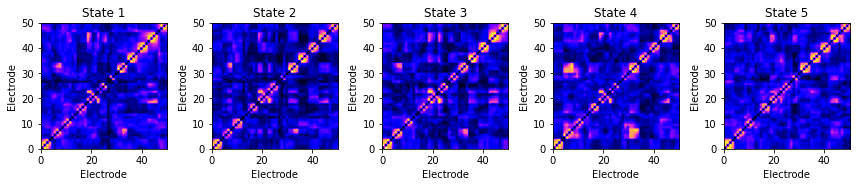

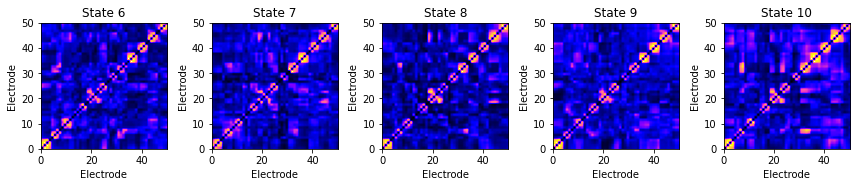

In [190]:
# plot representative states
# plot five per row
for row in range(int(np.floor(np.max(config_comm)/5))):
    fig, axs = plt.subplots(1,5,figsize=(12,12))
    for state in range(1+(5*row),1+(5*(row+1))):
        if state < np.max(config_comm)+1:
            axs[(state % 5)-1].imshow(np.flipud(rep_matrices[state]), extent=[0, patient_matrices[0].shape[0], 0, patient_matrices[0].shape[1]], cmap='gnuplot2')
            axs[(state % 5)-1].set_xlabel("Electrode")
            axs[(state % 5)-1].set_ylabel("Electrode")
            axs[(state % 5)-1].title.set_text("State {}".format(state))
    plt.tight_layout()
    plt.show()

In [194]:
# calculate state transition matrices
state_trans_matrices = np.zeros((1,int(np.max(state_list)),int(np.max(state_list))))
# for each segment
for start in range(0,len(state_list),sample_length):
    state_trans = np.zeros((np.max(state_list),np.max(state_list)))
    for frame in range(start,start+sample_length-1):
        # keep track of transition
        state_trans[state_list[frame]-1][state_list[frame+1]-1] = state_trans[state_list[frame]-1][state_list[frame+1]-1]+1
    # divide by total number of transitions to obtain probabilities
    state_trans = np.divide(state_trans,sample_length-1)
    state_trans = state_trans + state_trans.T
    state_trans_matrices = np.concatenate((state_trans_matrices,state_trans[np.newaxis,:,:]),axis=0)

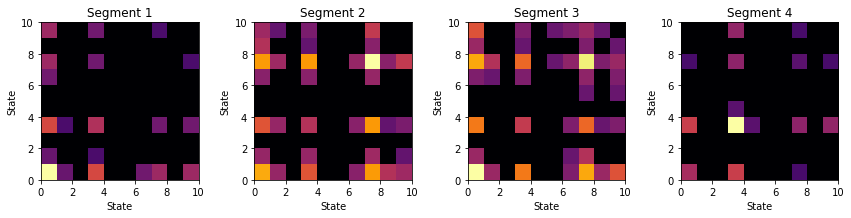

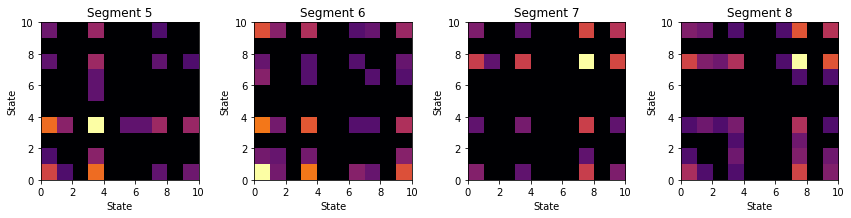

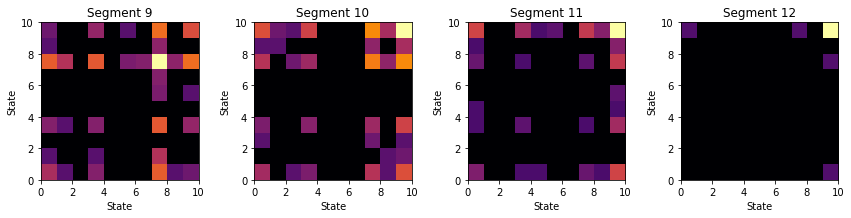

In [208]:
# plot representative states
# plot five per row
for row in range(int(np.floor(len(state_trans_matrices)/4))):
    fig, axs = plt.subplots(1,4,figsize=(12,12))
    for seg in range(1+(4*row),1+(4*(row+1))):
        if seg < len(state_trans_matrices):
            axs[(seg % 4)-1].imshow(np.power(np.flipud(state_trans_matrices[seg]),1/4), extent=[0, int(np.max(state_list)), 0, int(np.max(state_list))], cmap="inferno")
            axs[(seg % 4)-1].set_xlabel("State")
            axs[(seg % 4)-1].set_ylabel("State")
            axs[(seg % 4)-1].title.set_text("Segment {}".format(seg))
    plt.tight_layout()
    plt.show()